In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout



2023-03-26 20:42:44.571369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 20:42:44.657290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-26 20:42:44.657307: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-26 20:42:45.217385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [3]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

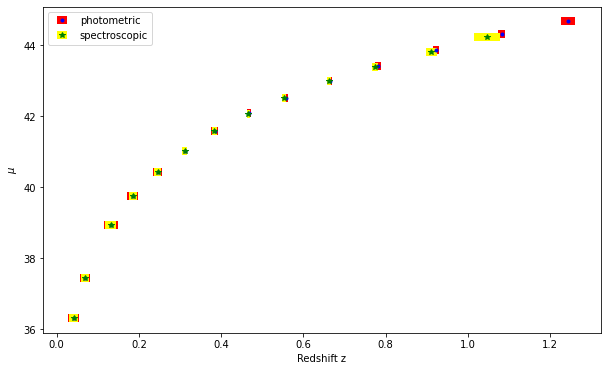

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [5]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [6]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [7]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [8]:
randomize = np.random.permutation(Np)
data_p = dfp.values[randomize]

z = data_p[:,0]
y = data_p[:,1:]

In [9]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [12]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((11, 1), (11, 1), (3, 1), (3, 1))

In [13]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.summary()


2023-03-26 20:42:46.064524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-26 20:42:46.064562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: isidro-PC
2023-03-26 20:42:46.064571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: isidro-PC
2023-03-26 20:42:46.064708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.5
2023-03-26 20:42:46.064737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.5
2023-03-26 20:42:46.064744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.5
2023-03-26 20:42:46.066162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAP

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 MCDropout_1 (MCDropout)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

In [14]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))



Epoch 1/1000
3/3 [==============================] - 1s 55ms/step - loss: 854.7864 - val_loss: 860.6120
Epoch 2/1000
3/3 [==============================] - 0s 9ms/step - loss: 848.2303 - val_loss: 850.2404
Epoch 3/1000
3/3 [==============================] - 0s 9ms/step - loss: 837.4754 - val_loss: 848.6968
Epoch 4/1000
3/3 [==============================] - 0s 10ms/step - loss: 826.9464 - val_loss: 841.8391
Epoch 5/1000
3/3 [==============================] - 0s 9ms/step - loss: 823.6257 - val_loss: 829.5995
Epoch 6/1000
3/3 [==============================] - 0s 9ms/step - loss: 804.2117 - val_loss: 821.1326
Epoch 7/1000
3/3 [==============================] - 0s 9ms/step - loss: 787.8807 - val_loss: 796.6213
Epoch 8/1000
3/3 [==============================] - 0s 10ms/step - loss: 767.0336 - val_loss: 800.9736
Epoch 9/1000
3/3 [==============================] - 0s 10ms/step - loss: 741.5936 - val_loss: 767.6136
Epoch 10/1000
3/3 [==============================] - 0s 9ms/step - loss: 701.7

3/3 [==============================] - 0s 9ms/step - loss: 17.0257 - val_loss: 38.8877
Epoch 82/1000
3/3 [==============================] - 0s 8ms/step - loss: 19.3017 - val_loss: 13.3549
Epoch 83/1000
3/3 [==============================] - 0s 8ms/step - loss: 39.8483 - val_loss: 51.7518
Epoch 84/1000
3/3 [==============================] - 0s 9ms/step - loss: 36.4244 - val_loss: 9.4294
Epoch 85/1000
3/3 [==============================] - 0s 9ms/step - loss: 17.0467 - val_loss: 22.7672
Epoch 86/1000
3/3 [==============================] - 0s 9ms/step - loss: 19.9159 - val_loss: 14.2683
Epoch 87/1000
3/3 [==============================] - 0s 9ms/step - loss: 37.9853 - val_loss: 67.7584
Epoch 88/1000
3/3 [==============================] - 0s 9ms/step - loss: 25.2609 - val_loss: 26.1428
Epoch 89/1000
3/3 [==============================] - 0s 8ms/step - loss: 22.5735 - val_loss: 11.7920
Epoch 90/1000
3/3 [==============================] - 0s 9ms/step - loss: 17.7079 - val_loss: 17.9746
Epoch

Epoch 162/1000
3/3 [==============================] - 0s 9ms/step - loss: 11.7548 - val_loss: 27.1051
Epoch 163/1000
3/3 [==============================] - 0s 9ms/step - loss: 28.4233 - val_loss: 18.3958
Epoch 164/1000
3/3 [==============================] - 0s 9ms/step - loss: 12.9486 - val_loss: 16.9176
Epoch 165/1000
3/3 [==============================] - 0s 9ms/step - loss: 11.8813 - val_loss: 5.5315
Epoch 166/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.7336 - val_loss: 21.3089
Epoch 167/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.9020 - val_loss: 24.3904
Epoch 168/1000
3/3 [==============================] - 0s 8ms/step - loss: 22.1800 - val_loss: 2.0134
Epoch 169/1000
3/3 [==============================] - 0s 9ms/step - loss: 25.6806 - val_loss: 30.3427
Epoch 170/1000
3/3 [==============================] - 0s 9ms/step - loss: 16.1512 - val_loss: 4.9354
Epoch 171/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.8425 - val

Epoch 243/1000
3/3 [==============================] - 0s 9ms/step - loss: 25.3629 - val_loss: 4.4910
Epoch 244/1000
3/3 [==============================] - 0s 10ms/step - loss: 11.4606 - val_loss: 12.6043
Epoch 245/1000
3/3 [==============================] - 0s 8ms/step - loss: 13.7119 - val_loss: 2.3765
Epoch 246/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.9468 - val_loss: 24.1413
Epoch 247/1000
3/3 [==============================] - 0s 9ms/step - loss: 20.0699 - val_loss: 2.3069
Epoch 248/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.4084 - val_loss: 17.6684
Epoch 249/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.8532 - val_loss: 9.6203
Epoch 250/1000
3/3 [==============================] - 0s 9ms/step - loss: 16.7479 - val_loss: 32.1075
Epoch 251/1000
3/3 [==============================] - 0s 9ms/step - loss: 17.1641 - val_loss: 7.0713
Epoch 252/1000
3/3 [==============================] - 0s 9ms/step - loss: 11.5155 - val_l

Epoch 324/1000
3/3 [==============================] - 0s 9ms/step - loss: 14.7204 - val_loss: 20.8876
Epoch 325/1000
3/3 [==============================] - 0s 9ms/step - loss: 12.1185 - val_loss: 7.5365
Epoch 326/1000
3/3 [==============================] - 0s 8ms/step - loss: 10.9820 - val_loss: 0.6986
Epoch 327/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.4774 - val_loss: 12.5649
Epoch 328/1000
3/3 [==============================] - 0s 9ms/step - loss: 15.1372 - val_loss: 12.0062
Epoch 329/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.0774 - val_loss: 2.9088
Epoch 330/1000
3/3 [==============================] - 0s 8ms/step - loss: 12.1304 - val_loss: 17.5991
Epoch 331/1000
3/3 [==============================] - 0s 8ms/step - loss: 10.0147 - val_loss: 6.0412
Epoch 332/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.5910 - val_loss: 2.5683
Epoch 333/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.3021 - val_lo

3/3 [==============================] - 0s 9ms/step - loss: 9.6435 - val_loss: 3.5998
Epoch 406/1000
3/3 [==============================] - 0s 9ms/step - loss: 14.6503 - val_loss: 13.4700
Epoch 407/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.9460 - val_loss: 9.1166
Epoch 408/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.1558 - val_loss: 6.0975
Epoch 409/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.6704 - val_loss: 7.0760
Epoch 410/1000
3/3 [==============================] - 0s 9ms/step - loss: 27.0353 - val_loss: 6.2420
Epoch 411/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.4676 - val_loss: 3.9661
Epoch 412/1000
3/3 [==============================] - 0s 9ms/step - loss: 4.7163 - val_loss: 30.2346
Epoch 413/1000
3/3 [==============================] - 0s 9ms/step - loss: 11.1063 - val_loss: 0.5605
Epoch 414/1000
3/3 [==============================] - 0s 9ms/step - loss: 4.8645 - val_loss: 2.5865
Epoch 415/

3/3 [==============================] - 0s 9ms/step - loss: 3.6915 - val_loss: 26.6488
Epoch 487/1000
3/3 [==============================] - 0s 10ms/step - loss: 9.7960 - val_loss: 3.5909
Epoch 488/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.8901 - val_loss: 16.4960
Epoch 489/1000
3/3 [==============================] - 0s 9ms/step - loss: 13.7689 - val_loss: 3.0104
Epoch 490/1000
3/3 [==============================] - 0s 9ms/step - loss: 13.3879 - val_loss: 3.4155
Epoch 491/1000
3/3 [==============================] - 0s 9ms/step - loss: 5.3233 - val_loss: 4.4289
Epoch 492/1000
3/3 [==============================] - 0s 8ms/step - loss: 6.4400 - val_loss: 5.4129
Epoch 493/1000
3/3 [==============================] - 0s 9ms/step - loss: 5.5218 - val_loss: 16.8600
Epoch 494/1000
3/3 [==============================] - 0s 9ms/step - loss: 5.7326 - val_loss: 4.6331
Epoch 495/1000
3/3 [==============================] - 0s 9ms/step - loss: 4.6687 - val_loss: 10.1167
Epoch 4

3/3 [==============================] - 0s 9ms/step - loss: 3.9533 - val_loss: 7.8794
Epoch 568/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.1275 - val_loss: 0.4647
Epoch 569/1000
3/3 [==============================] - 0s 9ms/step - loss: 16.4989 - val_loss: 8.4868
Epoch 570/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.1813 - val_loss: 11.6471
Epoch 571/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.0675 - val_loss: 13.1459
Epoch 572/1000
3/3 [==============================] - 0s 9ms/step - loss: 8.6062 - val_loss: 10.7180
Epoch 573/1000
3/3 [==============================] - 0s 9ms/step - loss: 12.1737 - val_loss: 3.2497
Epoch 574/1000
3/3 [==============================] - 0s 9ms/step - loss: 8.5148 - val_loss: 7.3355
Epoch 575/1000
3/3 [==============================] - 0s 9ms/step - loss: 2.8572 - val_loss: 4.7946
Epoch 576/1000
3/3 [==============================] - 0s 8ms/step - loss: 15.8111 - val_loss: 12.1523
Epoch 57

3/3 [==============================] - 0s 9ms/step - loss: 14.4854 - val_loss: 11.4170
Epoch 649/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.3740 - val_loss: 3.8910
Epoch 650/1000
3/3 [==============================] - 0s 8ms/step - loss: 7.3338 - val_loss: 10.0665
Epoch 651/1000
3/3 [==============================] - 0s 9ms/step - loss: 13.7078 - val_loss: 10.5084
Epoch 652/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.1034 - val_loss: 2.6352
Epoch 653/1000
3/3 [==============================] - 0s 9ms/step - loss: 13.1540 - val_loss: 5.1269
Epoch 654/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.1837 - val_loss: 2.4155
Epoch 655/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.0242 - val_loss: 1.9998
Epoch 656/1000
3/3 [==============================] - 0s 10ms/step - loss: 7.4189 - val_loss: 21.6663
Epoch 657/1000
3/3 [==============================] - 0s 9ms/step - loss: 16.5709 - val_loss: 1.9012
Epoch 

3/3 [==============================] - 0s 9ms/step - loss: 16.6682 - val_loss: 3.4814
Epoch 730/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.2312 - val_loss: 2.2989
Epoch 731/1000
3/3 [==============================] - 0s 9ms/step - loss: 3.1274 - val_loss: 28.2317
Epoch 732/1000
3/3 [==============================] - 0s 8ms/step - loss: 7.6977 - val_loss: 6.7511
Epoch 733/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.0774 - val_loss: 7.5162
Epoch 734/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.1094 - val_loss: 2.8502
Epoch 735/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.6474 - val_loss: 6.6120
Epoch 736/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.3782 - val_loss: 0.8714
Epoch 737/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.5562 - val_loss: 1.0664
Epoch 738/1000
3/3 [==============================] - 0s 9ms/step - loss: 2.8078 - val_loss: 13.5557
Epoch 739/1

3/3 [==============================] - 0s 9ms/step - loss: 11.1963 - val_loss: 11.6106
Epoch 811/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.6994 - val_loss: 3.6496
Epoch 812/1000
3/3 [==============================] - 0s 9ms/step - loss: 15.4631 - val_loss: 6.4938
Epoch 813/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.4507 - val_loss: 14.9436
Epoch 814/1000
3/3 [==============================] - 0s 10ms/step - loss: 6.0622 - val_loss: 4.8182
Epoch 815/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.5837 - val_loss: 3.7423
Epoch 816/1000
3/3 [==============================] - 0s 9ms/step - loss: 5.2684 - val_loss: 15.9332
Epoch 817/1000
3/3 [==============================] - 0s 9ms/step - loss: 14.5397 - val_loss: 0.3682
Epoch 818/1000
3/3 [==============================] - 0s 9ms/step - loss: 4.5537 - val_loss: 5.3591
Epoch 819/1000
3/3 [==============================] - 0s 9ms/step - loss: 5.1443 - val_loss: 1.5842
Epoch 8

3/3 [==============================] - 0s 9ms/step - loss: 13.8552 - val_loss: 27.0442
Epoch 892/1000
3/3 [==============================] - 0s 9ms/step - loss: 11.1688 - val_loss: 3.8464
Epoch 893/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.2787 - val_loss: 2.5202
Epoch 894/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.9895 - val_loss: 10.8528
Epoch 895/1000
3/3 [==============================] - 0s 9ms/step - loss: 4.7723 - val_loss: 6.5254
Epoch 896/1000
3/3 [==============================] - 0s 9ms/step - loss: 12.2966 - val_loss: 4.4669
Epoch 897/1000
3/3 [==============================] - 0s 9ms/step - loss: 4.7693 - val_loss: 14.0090
Epoch 898/1000
3/3 [==============================] - 0s 8ms/step - loss: 4.3180 - val_loss: 2.8037
Epoch 899/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.5507 - val_loss: 9.4680
Epoch 900/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.4907 - val_loss: 4.5767
Epoch 9

3/3 [==============================] - 0s 9ms/step - loss: 7.3534 - val_loss: 7.7278
Epoch 973/1000
3/3 [==============================] - 0s 9ms/step - loss: 8.5421 - val_loss: 12.3511
Epoch 974/1000
3/3 [==============================] - 0s 9ms/step - loss: 9.7827 - val_loss: 8.8318
Epoch 975/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.3291 - val_loss: 3.5648
Epoch 976/1000
3/3 [==============================] - 0s 9ms/step - loss: 3.2656 - val_loss: 4.6806
Epoch 977/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.7370 - val_loss: 3.1810
Epoch 978/1000
3/3 [==============================] - 0s 9ms/step - loss: 11.2653 - val_loss: 2.8139
Epoch 979/1000
3/3 [==============================] - 0s 9ms/step - loss: 6.9389 - val_loss: 12.5585
Epoch 980/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.7575 - val_loss: 2.1515
Epoch 981/1000
3/3 [==============================] - 0s 9ms/step - loss: 10.3757 - val_loss: 1.8171
Epoch 982/

In [15]:
model_train.history['val_loss'][-1]

8.636641502380371

In [16]:


# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.5, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



32/32 [==============================] - 0s 768us/step


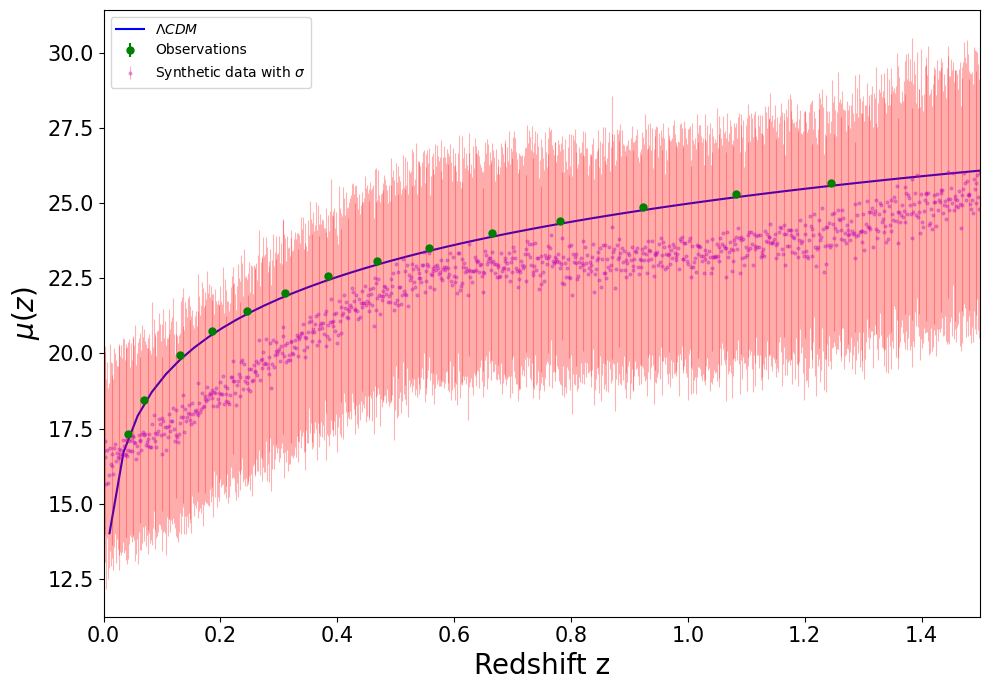

In [17]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.5)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors

(0.0, 50.0)

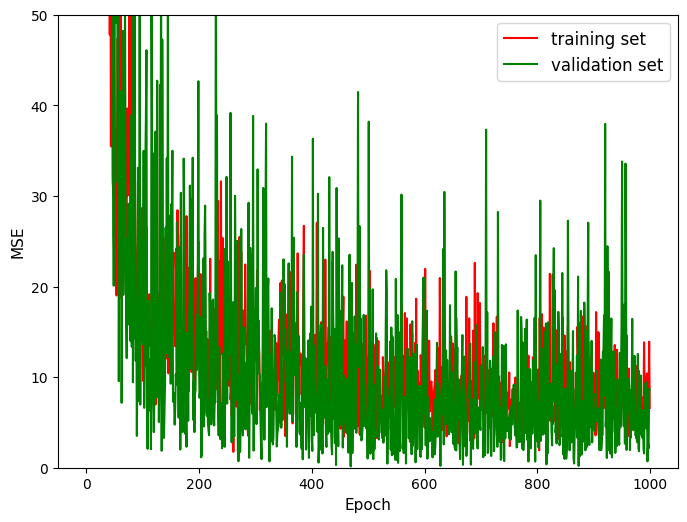

In [18]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 50)
